In [1]:
%pylab inline
%autosave 20
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['KERAS_BACKEND']='theano'
import keras
import sys
sys.path.append('/home/peter')
sys.path.append('/home/peter/code/projects/MultiNEAT')
sys.path.append('/home/ubuntu')
from universal import *
sys.path.append('/home/peter/code/projects')
sys.path.append('/home/peter/code/work/automl')
sys.path.append('/home/peter/code/projects/deepneat')
sys.path.append('/home/ubuntu')
sys.path.append('/home/ubuntu/new/automl')
from aidevutil import *
from keras.utils.vis_utils import plot_model
from tqdm import tqdm_notebook as tqdm
from deepneat import *
from sklearn.model_selection import StratifiedKFold
from project_common import *

Populating the interactive namespace from numpy and matplotlib


Autosaving every 20 seconds


Using Theano backend.
Using cuDNN version 7103 on context None
Mapped name None to device cuda: GeForce GTX 1050 with Max-Q Design (0000:02:00.0)


vizdoom could not be imported
Pixiedust database opened successfully


[MLENS] backend: threading


In [2]:
from dask import compute, delayed, persist
from dask.distributed import Client, wait
from dask.distributed import as_completed

In [3]:
import ipywidgets as widgets

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
from sklearn.svm import SVC

### Load data

In [6]:
(x_train, y_train), (x_test, y_test) = get_mnist(size=(5,5), nrows=4000, nrows_test=500)
dx = x_train.reshape(x_train.shape[0], -1)
dy = y_train.reshape(-1, 1)

dx_test = x_test.reshape(x_test.shape[0], -1)

In [7]:
def revsigm(data):
    return 1.-(1./(1.+np.exp(-data)))

def Outputs(data):
    return np.round(revsigm(data))
    
def MungeData(data):
    # Sex
    data.drop(['Ticket', 'Name'], inplace=True, axis=1)
    data.Sex.fillna('0', inplace=True)
    data.loc[data.Sex != 'male', 'Sex'] = 0
    data.loc[data.Sex == 'male', 'Sex'] = 1
    # Cabin
    cabin_const = 1
    data.Cabin.fillna(str(cabin_const), inplace=True)
    data.loc[data.Cabin.str[0] == 'A', 'Cabin'] = cabin_const
    data.loc[data.Cabin.str[0] == 'B', 'Cabin'] = cabin_const
    data.loc[data.Cabin.str[0] == 'C', 'Cabin'] = cabin_const
    data.loc[data.Cabin.str[0] == 'D', 'Cabin'] = cabin_const
    data.loc[data.Cabin.str[0] == 'E', 'Cabin'] = cabin_const
    data.loc[data.Cabin.str[0] == 'F', 'Cabin'] = cabin_const
    data.loc[data.Cabin.str[0] == 'G', 'Cabin'] = cabin_const
    data.loc[data.Cabin.str[0] == 'T', 'Cabin'] = cabin_const
    # Embarked
    data.loc[data.Embarked == 'C', 'Embarked'] = 1
    data.loc[data.Embarked == 'Q', 'Embarked'] = 2
    data.loc[data.Embarked == 'S', 'Embarked'] = 3
    data.Embarked.fillna(0, inplace=True)
    data.fillna(-1, inplace=True)
    return data.astype(float)

if socket.gethostname() in ['desktop','laptop']:
    train = pd.read_csv("../../work/automl/titanic/train.csv", dtype={"Age": np.float64}, )
    test = pd.read_csv("../../work/automl/titanic/test.csv", dtype={"Age": np.float64}, )
else:
    train = pd.read_csv("/home/ubuntu/new/automl/titanic/train.csv", dtype={"Age": np.float64}, )
    test = pd.read_csv("/home/ubuntu/new/automl/titanic/test.csv", dtype={"Age": np.float64}, )
    
mdt = MungeData(train)

dy = mdt['Survived'].values
dx = mdt.drop(['Survived'], axis=1).values
dx_test_df = MungeData(test)
dx_test = dx_test_df.values

In [8]:
dx.shape, dy.shape

((891, 9), (891,))

In [9]:
dx.shape, dy.shape

((891, 9), (891,))

In [10]:
###################
# Prototype Nodes #
###################
#
# Linear, PCA
#
# LogisticRegression, SVC, DecisionTreeClassifier
#
#

In [11]:
# NEAT Parameters 
params = NEAT.Parameters()

params.PopulationSize = 300
params.DynamicCompatibility = True
params.YoungAgeTreshold = 3
params.SpeciesMaxStagnation = 10
params.OldAgeTreshold = 10
params.MinSpecies = 1
params.MaxSpecies = 12
params.RouletteWheelSelection = False
params.ArchiveEnforcement = False
params.InnovationsForever = True

params.ConstraintTrials = 128

params.MutateAddNeuronProb = 0.15/3
params.MutateAddLinkProb = 0.5/3
params.MutateRemLinkProb = 0.1/3
params.RecurrentProb = 0.0
params.MaxWeight = 1.0

params.MutateWeightsProb = 0.0
params.MutateActivationAProb = 0.0
params.MutateActivationBProb = 0.0
params.MutateNeuronTimeConstantsProb = 0.0
params.MutateNeuronBiasesProb = 0.0

params.MutateGenomeTraitsProb = 0.0
params.MutateNeuronTraitsProb = 0.5
params.MutateLinkTraitsProb = 0.0

params.OverallMutationRate = 0.5
params.CrossoverRate = 0.7
params.MultipointCrossoverRate = 0.4
params.SurvivalRate = 0.2
params.InterspeciesCrossoverRate = 0.005
params.PreferFitterParentRate = 0.5

params.DontUseBiasNeuron = True
params.AllowLoops = False
params.AllowClones = True

params.ExcessCoeff = 1.0
params.DisjointCoeff = 1.0

params.WeightDiffCoeff = 0.0
params.TimeConstantDiffCoeff = 0.0
params.BiasDiffCoeff = 0.0
params.ActivationADiffCoeff = 0.0
params.ActivationBDiffCoeff = 0.0
params.NormalizeGenomeSize = True

params.MinCompatTreshold = 0.0
params.CompatTreshold = 1.25
params.CompatTreshChangeInterval_Evaluations = 1
params.CompatTresholdModifier = 0.002

### Base trait class

In [12]:
class BaseObject: 
    def __init__(self):
        pass
        
    def mate(self, other):
        baby = BaseObject()
        return baby
    
    def mutate(self):
        baby = BaseObject()
        return baby
    
    def distance_to(self, other):
        return rnd.uniform(0,1)

    def fit(self, x, y):
        pass
    
    def transform(self, x, y):
        return np.array(x)

### Derived Classes

#### PCA

In [13]:
class genePCA(BaseObject): 
    def __init__(self):
        self.ndim = rnd.randint(1, 16)
        self.pca = PCA(n_components=self.ndim)
        
    def __repr__(self):
        return "PCA(%d)" % self.ndim
    
    def mate(self, other):
        if isinstance(other, genePCA):
            baby = genePCA()
            baby.ndim = (self.ndim + other.ndim)//2
            baby.pca = PCA(n_components=baby.ndim)
            return baby
        else:
            return rnd.choice([self, other])
    
    def mutate(self):
        baby = genePCA()
        baby.ndim += rnd.randint(-3, 3)
        baby.ndim = np.clip(baby.ndim, 2, 16)
        baby.pca = PCA(n_components=baby.ndim)
        return baby
    
    def distance_to(self, other):
        if isinstance(other, genePCA):
            return float(np.abs(self.ndim - other.ndim))
        else:
            return 100000.0
    
    def fit(self, x, y=None):
        self.pca.fit(x, y=y)
        
    def transform(self, x, y):
        xt = self.pca.transform(x)
        return np.array(xt)

#### Linear

In [14]:
class geneLinear(BaseObject): 
    def __init__(self):
        pass
    
    def __repr__(self):
        return "Linear"
    
    def mate(self, other):
        return rnd.choice([self, other])
    
    def mutate(self):
        return self
    
    def distance_to(self, other):
        if isinstance(other, geneLinear):
            return 0.0
        else:
            return 100000.0
    
    def fit(self, x, y):
        pass
    
    def transform(self, x, y):
        return np.array(x)

#### LogisticRegression

In [15]:
class geneLogisticRegression(BaseObject): 
    def __init__(self):
        ps = {}
        ps['penalty'] = rnd.choice(['l1','l2'])
        ps['dual'] = rnd.choice([True, False])
        ps['fit_intercept'] = rnd.choice([True, False])
        
        self.ps = ps
        self.clf = LogisticRegression(**ps, max_iter=10000)
        
    def __repr__(self):
        return "LGRG(%s,%s,%s)" % (self.ps['penalty'], self.ps['dual'], self.ps['fit_intercept'])
    
    def mate(self, other):
        if isinstance(other, geneLogisticRegression):
            baby = geneLogisticRegression()
            ps = self.ps
            if rnd.uniform(0,1)<0.5: ps['penalty'] = rnd.choice([self.ps['penalty'], other.ps['penalty']])
            if rnd.uniform(0,1)<0.5: ps['dual'] = rnd.choice([self.ps['dual'], other.ps['dual']])
            if rnd.uniform(0,1)<0.5: ps['fit_intercept'] = rnd.choice([self.ps['fit_intercept'], other.ps['fit_intercept']])
            baby.clf = LogisticRegression(**ps)
            return baby
        else:
            return rnd.choice([self, other])
    
    def mutate(self):
        baby = geneLogisticRegression()
        ps = self.ps
        if rnd.uniform(0,1)<0.1: ps['penalty'] = rnd.choice(['l1','l2'])
        if rnd.uniform(0,1)<0.1: ps['dual'] = rnd.choice([True, False])
        if rnd.uniform(0,1)<0.1: ps['fit_intercept'] = rnd.choice([True, False])
        baby.clf = LogisticRegression(**ps)
        return baby
    
    def distance_to(self, other):
        if isinstance(other, geneLogisticRegression):
            return 0.0
        else:
            return 100000.0
    
    def fit(self, x, y):
        if len(y.shape)>1:
            y = y.reshape(-1)
        self.clf.fit(x, y)
        
    def transform(self, x, y):
        return self.clf.predict(x)

#### DecisionTreeClassifier

In [16]:
class geneDecisionTreeClassifier(BaseObject): 
    def __init__(self):
        ps = {}
        ps['criterion'] = rnd.choice(['gini','entropy'])
        ps['splitter'] = rnd.choice(['best', 'random'])
        ps['max_depth'] = rnd.choice([None, 1, 3, 5])
        ps['max_features'] = rnd.choice([None, 0.25, 0.5, 0.8])
        ps['min_samples_split'] = rnd.choice([2,3])
        
        self.ps = ps
        self.clf = DecisionTreeClassifier(**ps)
        
    def __repr__(self):
        return "DTC(%s,%s,%s,%s,%s)" % (self.ps['criterion'], 
                                  self.ps['splitter'], 
                                  self.ps['max_depth'],
                                  self.ps['max_features'],
                                  self.ps['min_samples_split'])
    
    def mate(self, other):
        if isinstance(other, geneDecisionTreeClassifier):
            baby = geneDecisionTreeClassifier()
            ps = self.ps
            if rnd.uniform(0,1)<0.5: ps['criterion'] = rnd.choice([self.ps['criterion'], other.ps['criterion']])
            if rnd.uniform(0,1)<0.5: ps['splitter'] = rnd.choice([self.ps['splitter'], other.ps['splitter']])
            if rnd.uniform(0,1)<0.5: ps['max_depth'] = rnd.choice([self.ps['max_depth'], other.ps['max_depth']])
            if rnd.uniform(0,1)<0.5: ps['max_features'] = rnd.choice([self.ps['max_features'], other.ps['max_features']])
            if rnd.uniform(0,1)<0.5: ps['min_samples_split'] = rnd.choice([self.ps['min_samples_split'], 
                                                                           other.ps['min_samples_split']])
            baby.clf = DecisionTreeClassifier(**ps)
            return baby
        else:
            return rnd.choice([self, other])
    
    def mutate(self):
        baby = geneDecisionTreeClassifier()
        
        ps = self.ps
        if rnd.uniform(0,1)<0.1: ps['criterion'] = rnd.choice(['gini','entropy'])
        if rnd.uniform(0,1)<0.1: ps['splitter'] = rnd.choice(['best', 'random'])
        if rnd.uniform(0,1)<0.1: ps['max_depth'] = rnd.choice([None, 1, 3, 5])
        if rnd.uniform(0,1)<0.1: ps['max_features'] = rnd.choice([None, 0.25, 0.5, 0.8])
        if rnd.uniform(0,1)<0.1: ps['min_samples_split'] = rnd.choice([2,3])
        baby.clf = DecisionTreeClassifier(**ps)
        
        return baby
    
    def distance_to(self, other):
        if isinstance(other, geneDecisionTreeClassifier):
            return 0.0
        else:
            return 100000.0
    
    def fit(self, x, y):
        if len(y.shape)>1:
            y = y.reshape(-1)
        self.clf.fit(x, y)
        
    def transform(self, x, y):
        return self.clf.predict(x)

#### SVC

In [17]:
class geneSVC(BaseObject): 
    def __init__(self):
        ps = {}
        ps['C'] = rnd.choice([0.1, 1.0, 10.0])
        ps['kernel'] = rnd.choice(['linear', 'rbf'])
        ps['probability'] = rnd.choice([True, False])
        
        self.ps = ps
        self.clf = SVC(**ps)
        
    def __repr__(self):
        return "SVC(%s,%s,%s)" % (self.ps['C'], 
                                  self.ps['kernel'],
                                  self.ps['probability'])
    
    def mate(self, other):
        if isinstance(other, geneSVC):
            baby = geneSVC()
            ps = self.ps
            if rnd.uniform(0,1)<0.5: ps['C'] = rnd.choice([self.ps['C'], other.ps['C']])
            if rnd.uniform(0,1)<0.5: ps['kernel'] = rnd.choice([self.ps['kernel'], other.ps['kernel']])
            if rnd.uniform(0,1)<0.5: ps['probability'] = rnd.choice([self.ps['probability'], other.ps['probability']])
            baby.clf = SVC(**ps)
            return baby
        else:
            return rnd.choice([self, other])
    
    def mutate(self):
        baby = geneSVC()
        ps = self.ps
        if rnd.uniform(0,1)<0.1: ps['C'] = rnd.choice([0.1, 1.0, 10.0])
        if rnd.uniform(0,1)<0.1: ps['kernel'] = rnd.choice(['linear', 'rbf'])
        if rnd.uniform(0,1)<0.1: ps['probability'] = rnd.choice([True, False])
    
        baby.clf = SVC(**ps)
        return baby
    
    def distance_to(self, other):
        if isinstance(other, geneSVC):
            return 0.0
        else:
            return 100000.0
    
    def fit(self, x, y):
        if len(y.shape)>1:
            y = y.reshape(-1)
        self.clf.fit(x, y)
        
    def transform(self, x, y):
        if self.ps['probability']:
            return self.clf.predict_proba(x)
        else:
            return self.clf.predict(x)

#### LinearSVC

In [18]:
class geneLinearSVC(BaseObject): 
    def __init__(self):
        ps = {}
        ps['C'] = rnd.choice([0.5, 0.75, 0.95, 1.0])
        
        self.ps = ps
        self.clf = LinearSVC(**ps, max_iter=10000)
        
    def __repr__(self):
        return "LinearSVC(%s)" % (self.ps['C'])
    
    def mate(self, other):
        if isinstance(other, geneLinearSVC):
            baby = geneLinearSVC()
            ps = self.ps
            if rnd.uniform(0,1)<0.5: ps['C'] = rnd.choice([self.ps['C'], other.ps['C']])
            baby.clf = LinearSVC(**ps)
            return baby
        else:
            return rnd.choice([self, other])
    
    def mutate(self):
        baby = geneLinearSVC()
        ps = self.ps
        if rnd.uniform(0,1)<0.1: ps['C'] = rnd.choice([0.5, 0.75, 0.95, 1.0])
        baby.clf = LinearSVC(**ps)
        return baby
    
    def distance_to(self, other):
        if isinstance(other, geneLinearSVC):
            return 0.0
        else:
            return 100000.0
    
    def fit(self, x, y):
        if len(y.shape)>1:
            y = y.reshape(-1)
        self.clf.fit(x, y)
        
    def transform(self, x, y):
        return self.clf.predict(x)

#### KNeighborsClassifier

In [19]:
class geneKNeighborsClassifier(BaseObject): 
    def __init__(self):
        ps = {}
        ps['weights'] = rnd.choice(['uniform', 'distance'])
        ps['algorithm'] = rnd.choice(['auto', 'ball_tree', 'kd_tree', 'brute'])
        ps['n_neighbors'] = rnd.choice([2, 4, 8, 15, 25])
        ps['leaf_size'] = rnd.choice([10, 25, 50, 75])
        ps['p'] = rnd.choice([2, 3])
        
        self.ps = ps
        self.clf = KNeighborsClassifier(**ps)
        
    def __repr__(self):
        return "KNC(%s)" % (str(self.ps))
    
    def mate(self, other):
        if isinstance(other, geneKNeighborsClassifier):
            baby = geneKNeighborsClassifier()
            ps = self.ps
            if rnd.uniform(0,1)<0.5: ps['weights'] = rnd.choice([self.ps['weights'], other.ps['weights']])
            if rnd.uniform(0,1)<0.5: ps['algorithm'] = rnd.choice([self.ps['algorithm'], other.ps['algorithm']])
            if rnd.uniform(0,1)<0.5: ps['n_neighbors'] = rnd.choice([self.ps['n_neighbors'], other.ps['n_neighbors']])
            if rnd.uniform(0,1)<0.5: ps['leaf_size'] = rnd.choice([self.ps['leaf_size'], other.ps['leaf_size']])
            if rnd.uniform(0,1)<0.5: ps['p'] = rnd.choice([self.ps['p'], other.ps['p']])
            baby.clf = KNeighborsClassifier(**ps)
            return baby
        else:
            return rnd.choice([self, other])
    
    def mutate(self):
        baby = geneKNeighborsClassifier()
        ps = self.ps
        if rnd.uniform(0,1)<0.1: ps['weights'] = rnd.choice(['uniform', 'distance'])
        if rnd.uniform(0,1)<0.1: ps['algorithm'] = rnd.choice(['auto', 'ball_tree', 'kd_tree', 'brute'])
        if rnd.uniform(0,1)<0.1: ps['n_neighbors'] = rnd.choice([2, 4, 8, 15, 25])
        if rnd.uniform(0,1)<0.1: ps['leaf_size'] = rnd.choice([10, 25, 50, 75])
        if rnd.uniform(0,1)<0.1: ps['p'] = rnd.choice([2, 3])
        baby.clf = KNeighborsClassifier(**ps)
        return baby
    
    def distance_to(self, other):
        if isinstance(other, geneKNeighborsClassifier):
            return 0.0
        else:
            return 100000.0
    
    def fit(self, x, y):
        if len(y.shape)>1:
            y = y.reshape(-1)
        self.clf.fit(x, y)
        
    def transform(self, x, y):
        return self.clf.predict(x)

#### BaggingClassifier

In [20]:
class geneBaggingClassifier(BaseObject): 
    def __init__(self):
        ps = {}
        ps['n_estimators'] = rnd.choice([10, 50, 100, 200])
        ps['max_samples'] = rnd.choice([0.1, 0.33, 0.75, 1.0])
        
        self.ps = ps
        self.clf = BaggingClassifier(**ps)
        
    def __repr__(self):
        return "BaggingClf(%s, %s)" % (self.ps['n_estimators'], self.ps['max_samples'])
    
    def mate(self, other):
        if isinstance(other, geneBaggingClassifier):
            baby = geneBaggingClassifier()
            ps = self.ps
            if rnd.uniform(0,1)<0.5: ps['n_estimators'] = rnd.choice([self.ps['n_estimators'], other.ps['n_estimators']])
            if rnd.uniform(0,1)<0.5: ps['max_samples'] = rnd.choice([self.ps['max_samples'], other.ps['max_samples']])
            
            baby.clf = BaggingClassifier(**ps)
            return baby
        else:
            return rnd.choice([self, other])
    
    def mutate(self):
        baby = geneBaggingClassifier()
        ps = self.ps
        if rnd.uniform(0,1)<0.1: ps['n_estimators'] = rnd.choice([10, 50, 100, 200])
        if rnd.uniform(0,1)<0.1: ps['max_samples'] = rnd.choice([0.1, 0.33, 0.75, 1.0])
        
        baby.clf = BaggingClassifier(**ps)
        return baby
    
    def distance_to(self, other):
        if isinstance(other, geneBaggingClassifier):
            return 0.0
        else:
            return 100000.0
    
    def fit(self, x, y):
        if len(y.shape)>1:
            y = y.reshape(-1)
        self.clf.fit(x, y)
        
    def transform(self, x, y):
        return self.clf.predict(x)

#### GradientBoostingClassifier

In [21]:
class geneGradientBoostingClassifier(BaseObject): 
    def __init__(self):
        ps = {}
        ps['loss'] = rnd.choice(['deviance', 'exponential'])
        ps['max_depth'] = rnd.choice([1, 5, 10, 15])
        ps['max_features'] = rnd.choice(['sqrt', 'log2', None])
        ps['learning_rate'] = rnd.choice([0.001, 0.05, 0.2])
        ps['subsample'] = rnd.choice([0.5, 0.8, 0.95, 1.0])
        ps['n_estimators'] = rnd.choice([10, 100, 200, 300])
        
        self.ps = ps
        self.clf = GradientBoostingClassifier(**ps)
        
    def __repr__(self):
        return "BaggingClf(%s, %s)" % (self.ps['n_estimators'], self.ps['max_samples'])
    
    def mate(self, other):
        if isinstance(other, geneGradientBoostingClassifier):
            baby = geneGradientBoostingClassifier()
            ps = self.ps

            if rnd.uniform(0,1)<0.5: ps['loss'] = rnd.choice([self.ps['loss'], other.ps['loss']])
            if rnd.uniform(0,1)<0.5: ps['max_depth'] = rnd.choice([self.ps['max_depth'], other.ps['max_depth']])
            if rnd.uniform(0,1)<0.5: ps['max_features'] = rnd.choice([self.ps['max_features'], other.ps['max_features']])
            if rnd.uniform(0,1)<0.5: ps['learning_rate'] = rnd.choice([self.ps['learning_rate'], other.ps['learning_rate']])
            if rnd.uniform(0,1)<0.5: ps['subsample'] = rnd.choice([self.ps['subsample'], other.ps['subsample']])
            if rnd.uniform(0,1)<0.5: ps['n_estimators'] = rnd.choice([self.ps['n_estimators'], other.ps['n_estimators']])
            
            baby.clf = GradientBoostingClassifier(**ps)
            return baby
        else:
            return rnd.choice([self, other])
    
    def mutate(self):
        baby = geneGradientBoostingClassifier()
        ps = self.ps
        
        if rnd.uniform(0,1)<0.1: ps['loss'] = rnd.choice(['deviance', 'exponential'])
        if rnd.uniform(0,1)<0.1: ps['max_depth'] = rnd.choice([1, 5, 10, 15])
        if rnd.uniform(0,1)<0.1: ps['max_features'] = rnd.choice(['sqrt', 'log2', None])
        if rnd.uniform(0,1)<0.1: ps['learning_rate'] = rnd.choice([0.001, 0.05, 0.2])
        if rnd.uniform(0,1)<0.1: ps['subsample'] = rnd.choice([0.5, 0.8, 0.95, 1.0])
        if rnd.uniform(0,1)<0.1: ps['n_estimators'] = rnd.choice([10, 100, 200, 300])       
        
        baby.clf = GradientBoostingClassifier(**ps)
        return baby
    
    def distance_to(self, other):
        if isinstance(other, geneGradientBoostingClassifier):
            return 0.0
        else:
            return 100000.0
    
    def fit(self, x, y):
        if len(y.shape)>1:
            y = y.reshape(-1)
        self.clf.fit(x, y)
        
    def transform(self, x, y):
        return self.clf.predict(x)

### The GA

In [22]:
derived_list = [
                genePCA, 
                geneLinear, 
                geneLogisticRegression, 
                #geneDecisionTreeClassifier,
                #geneSVC, 
                geneLinearSVC,
                geneKNeighborsClassifier,
                geneBaggingClassifier,
               ]
probs = [1.0]*len(derived_list)

#### Genome constraints

In [23]:
def fails_constraints(genome):
    try:
        ts = genome.GetNeuronTraits()
        o = None
        for t in ts:
            if t[1]=='output': 
                o = t[2]
                break
        if not (isinstance(o['node'], geneLogisticRegression) or 
                isinstance(o['node'], geneSVC) or
                isinstance(o['node'], geneDecisionTreeClassifier) or
                isinstance(o['node'], geneKNeighborsClassifier)                
               ):
            return True
        else:
            return False
    except:
        return True
    return True

In [ ]:
params.CustomConstraints = fails_constraints

#### Traits setup

In [ ]:
# merge mode
s = ['concat',
    # when dimensions match, these can be done, otherwise it defaults to concat
     'add','mul','avg','min','max',
    ]
p = [1.0] * len(s)
mm = {'details': {'set': s, 'probs': p},
      'importance_coeff': 0.0,
      'mutation_prob': 0.3,
      'type': 'str'}

params.SetNeuronTraitParameters('mm', mm)

In [ ]:
node = {'details': (derived_list, probs),
          'importance_coeff': 0.1,
          'mutation_prob': 0.2,
          'type': 'pyclassset'}

params.SetNeuronTraitParameters('node', node)

#### Initialize population

In [ ]:
num_inputs = 1
num_outputs = 1

In [ ]:
num_input_dims = dx.shape[1]
num_output_dims = 1

In [ ]:
g = NEAT.Genome(0, num_inputs, 1, num_outputs, 0, NEAT.ActivationFunction.RELU,
                    NEAT.ActivationFunction.RELU, 0, params, 0, 1)

In [ ]:
pop = NEAT.Population(g, params, True, 1.0, 0)
pop.RNG.Seed(int(time.clock()*100))

In [ ]:
dx.shape, dy.shape

((891, 9), (891,))

In [ ]:
#dx[0:3]

In [ ]:
#dy[0:3]

In [ ]:
gr = NEAT.Genome2NX(pop.Species[0].Individuals[0])

In [ ]:
gr.nodes(data=1)

[(1, {}), (2, {'mm': 'min', 'node': LGRG(l2,False,True)})]

#### Activate graph

In [ ]:
def activate_graph(gr, inputs, targets, num_outputs=1, fit=True):
    allnodes = list(nx.dfs_postorder_nodes(gr))[::-1]
    for a in allnodes: gr.node[a]['act'] = None
    
    # separate input from non-input nodes
    allnodes = [x for x in allnodes if x > num_inputs]
    
    # input the data
    for i,inp in zip(range(1, num_inputs+1), inputs): 
        gr.node[i]['act'] = np.array(inp).reshape(inp.shape[0], -1)
        
    # pass through the graph
    for an in allnodes:
        #print(gr.node[a], end=' ')
        mm = gr.node[an]['mm']
        
        # collect the inputs to this node
        
        # also sort the incoming edges by id for consistency
        inedg = list(gr.in_edges(an))
        inps = [gr.node[i]['act'] for i,o in inedg]
        
        if (mm == 'concat') or (len(inps)==1) or (not all([x.shape[1] == inps[0].shape[1] for x in inps])):  
            if len(inps)>1:
                iii = np.concatenate(inps, axis=1)
            else:
                if isinstance(inps, list):
                    iii = inps[0]
                else:
                    iii = inps
        else:
            iii = np.array(inps)
            if mm == 'add':
                iii = np.sum(inps, axis=0)
            elif mm == 'mul':
                iii = np.prod(inps, axis=0)
            elif mm == 'avg':
                iii = np.mean(inps, axis=0)
            elif mm == 'min':
                iii = np.min(inps, axis=0)
            elif mm == 'max':
                iii = np.max(inps, axis=0)
            else:
                iii = np.array(iii)
        
        if fit: gr.node[an]['node'].fit(iii, targets)
        act = gr.node[an]['node'].transform(iii, targets).reshape(iii.shape[0], -1)
        
        # store activation
        gr.node[an]['act'] = act

    outputs = [gr.node[o]['act'] for o in allnodes[-num_outputs:]]
    return np.array(outputs)[0]

In [ ]:
try:
    a = activate_graph(gr, [dx], dy)
    a.shape
except Exception as ex:
    print(ex)

(891, 1)

#### Evaluate

In [ ]:
# evaluation function
pred_mode = 'c'

def evaluate(args):
    idx, gr, dx, dy, ltr, ntr, precomp = args
    ntr = [x for x in ntr if x[1]!='input']
    
    if pred_mode=='r':
        pdy = np.digitize(dy, bins=np.linspace(min(dy), max(dy),10))
    else:
        pdy = dy
    
    try:
        acc = 0 
        
        for trial in range(num_trials):

            skf = StratifiedKFold(n_splits=CV_splits, shuffle=True, 
                                  random_state = rnd.randint(0, 100000)
                                 )
            cvavg_tr = 0
            cvavg_ts = 0
            for tr, ts in (skf.split(dx, pdy)):
                x_train = dx[tr]
                y_train = dy[tr]
                x_test = dx[ts]
                y_test = dy[ts]

                a_tr = activate_graph(gr, [x_train], y_train, fit=True)
                a_ts = activate_graph(gr, [x_test], y_test, fit=False)

                def fixx(x):
                    if x.shape[1] > 1: 
                        x = np.sum(x, axis=1)
                        x = np.round((np.tanh(x) + 1.0)/2.0)
                    return x.reshape(x.shape[0],-1)

                a = fixx(a_tr)
                b = fixx(a_ts)

                acc_tr = np.sum(a.reshape(-1) == y_train.reshape(-1)) / len(a.reshape(-1))
                acc_ts = np.sum(b.reshape(-1) == y_test.reshape(-1)) / len(b.reshape(-1))
                cvavg_tr += acc_tr
                cvavg_ts += acc_ts

            acc += float(cvavg_ts / CV_splits)
        
        acc /= num_trials
        
    except Exception as ex:
        
        print(ex)
        acc = 0.0
    
    f = acc
    
    return idx, f, None

In [ ]:
def decide(x):
    return x 

#### Cluster init

##### IPs

In [ ]:
if socket.gethostname() == 'laptop':
    cluster='192.168.0.108:8786'
elif socket.gethostname() == 'desktop':
    clsuter='192.168.0.108:8786'
else:
    cluster='172.31.43.76:8786'

##### Scatter objects

In [ ]:
import time
st = time.time()
print('Connecting..')
if cluster:
    client = Client(cluster)
else:
    client = Client()
client.restart(timeout=600)
# push the data to the cluster
print('Scattering data to cluster..')
debugxy=0
if not debugxy:
    fx = client.scatter(dx, broadcast=True, direct=True)
    fy = client.scatter(dy, broadcast=True, direct=True)
else:
    fx, fy = None, None
print(f'done in {time.time()-st} seconds')

Connecting..


Client Scheduler: tcp://192.168.0.108:8786 Dashboard: http://192.168.0.108:8787/status,Cluster Workers: 16 Cores: 16 Memory: 96.77 GB


Scattering data to cluster..
done in 2.1494197845458984 seconds


In [ ]:
#evaluate((0, NEAT.Genome2NX(pop.Species[0].Individuals[2]), dx, dy))

### Parameters

In [ ]:
num_trials = 5
CV_splits = 5

In [ ]:
parallel = 1
precomp = None
verbose=1
use_local_search=0
display_whole_pop = 0
display_max_species = 8
initeval = 0
evaluations = 2000
display_pop_each = 80000
once = False
x_shape, ys = dx.shape[1], 1
population = params.PopulationSize

penalize_stangation = 1
penalize_stagnation_evals = 2400

max_stagnation = 5000

max_nodeslinks_to_output = 4

evhist = []
best_ever = 0
best_gs = []

#### Utility stuff

In [ ]:
def poplen(pop):
    return sum([len(x.Individuals) for x in pop.Species])

In [ ]:
def prettydict(d, nonl=False):
    i,t,di = d
    if not nonl:
        ks = '%d - %s: ' % (i, t)
    else:
        return '%d - %s' % (i, t)
    s = []
    for k,v in sorted(list(di.items())):
        if isinstance(v, float):
            s.append( '%s %3.3f' % (k[0:1], v) )
        else:
            s.append( '%s %s' % (k[0:1], v) )
    return ks + ', '.join(s)

In [ ]:
def species_display(pop):
    genomes = [x.GetLeader() for x in pop.Species][0:display_max_species]
    f, axes = plt.subplots(1, len(genomes), figsize=(len(genomes) * 4.5, 14))
    print('Species Representatives:')
    if len(genomes)>1:
        for i,(ax, g) in enumerate(zip(axes, genomes)):
            try:
                img = NEAT.viz.Draw(g, size=(300, 400))[:, 0:230]
                ax.imshow(img)
                ax.set_title('%3.6f | %3.2f%%' % (decide(g.GetFitness()),
                                                  (len(pop.Species[i].Individuals)/poplen(pop))*100 ))
                s = '\n'.join([prettydict(x) for x in g.GetNeuronTraits() if x[1] != 'input'][0:8])
                s += '\n=============\n'
                s += '\n'.join([prettydict(x, nonl=True) for x in g.GetLinkTraits(False)][0:8])
                ax.set_xlabel(s)
            except Exception as ex:
                print(ex)
    else:
        try:
            g = pop.GetBestGenome()
            img = NEAT.viz.Draw(g, size=(300, 400))[:, 0:230]
            axes.imshow(img)
            axes.set_title('%3.6f' % (decide(g.GetFitness())))
            s = '\n'.join([prettydict(x) for x in g.GetNeuronTraits() if x[1] != 'input'][0:8])
            s += '\n=============\n'
            s += '\n'.join([prettydict(x, nonl=True) for x in g.GetLinkTraits(False)][0:8])
            axes.set_xlabel(s)
        except Exception as ex:
            print(ex)
    f.tight_layout()
    plt.show()

### Main loop

0it [00:00, ?it/s]

rtNEAT phase


Evaluated: 0 CTresh: 1.250000 Species: 2 Last fitness: 0.000000 [] (Elapsed Time: 0:00:00) /  0.0 s/individuals

NEW RECORD!
Evaluations: 2 Fitness: 0.7885455177997487
-------- nodes: 2 -------- 
[2, 'output', {'mm': 'avg', 'node': LGRG(l1,False,True)}]
-------- links: 1 -------- 
[1, 2, {}, -5.285612295148894]
----------------------- 
Species Representatives:


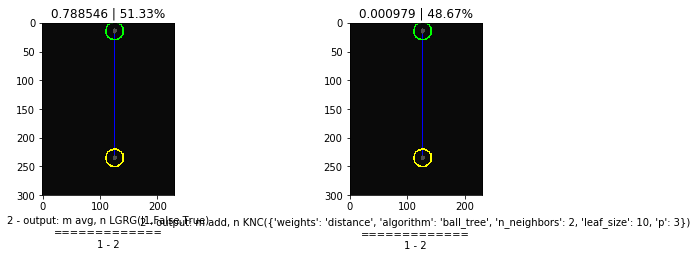

Evaluated: 4 CTresh: 1.250000 Species: 2 Last fitness: 0.000000 [] (Elapsed Time: 0:00:00) \  4.2 individuals/s

NEW RECORD!
Evaluations: 5 Fitness: 0.7894668923574724
-------- nodes: 2 -------- 
[2, 'output', {'mm': 'avg', 'node': LGRG(l1,False,False)}]
-------- links: 1 -------- 
[1, 2, {}, -5.7203755881637335]
----------------------- 
Species Representatives:


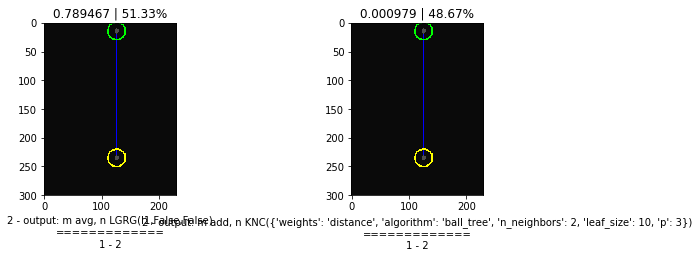

Evaluated: 6 CTresh: 1.250000 Species: 2 Last fitness: 0.787374 [] (Elapsed Time: 0:00:01) /  3.6 individuals/s

NEW RECORD!
Evaluations: 7 Fitness: 0.7930640080261382
-------- nodes: 2 -------- 
[2, 'output', {'mm': 'concat', 'node': LGRG(l2,False,True)}]
-------- links: 1 -------- 
[1, 2, {}, -3.5394489851314574]
----------------------- 
Species Representatives:


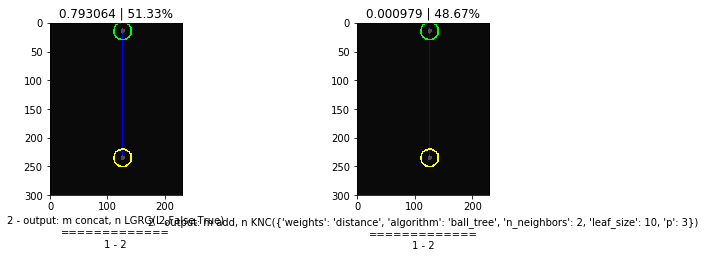

Evaluated: 7 CTresh: 1.250000 Species: 2 Last fitness: 0.793064 [] (Elapsed Time: 0:00:02) -  3.3 individuals/s

NEW RECORD!
Evaluations: 11 Fitness: 0.793450434376781
-------- nodes: 2 -------- 
[2, 'output', {'mm': 'min', 'node': LGRG(l2,False,False)}]
-------- links: 1 -------- 
[1, 2, {}, -1.4831335151102394]
----------------------- 
Species Representatives:


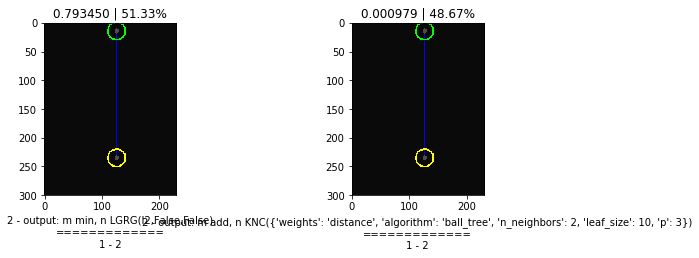

Evaluated: 21 CTresh: 1.250000 Species: 2 Last fitness: 0.788091 [] (Elapsed Time: 0:00:02) |  8.0 individuals/s

NEW RECORD!
Evaluations: 24 Fitness: 0.7939489188367774
-------- nodes: 2 -------- 
[2, 'output', {'mm': 'min', 'node': LGRG(l2,False,True)}]
-------- links: 1 -------- 
[1, 2, {}, -5.466916454490274]
----------------------- 
Species Representatives:


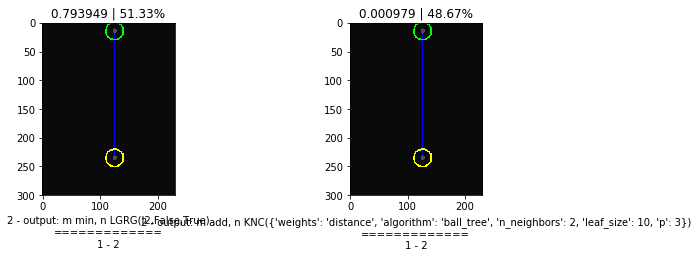

Evaluated: 32 CTresh: 1.250000 Species: 2 Last fitness: 0.000000 [] (Elapsed Time: 0:00:03) \ 10.2 individuals/s

NEW RECORD!
Evaluations: 35 Fitness: 0.7946457728899381
-------- nodes: 2 -------- 
[2, 'output', {'mm': 'mul', 'node': LGRG(l2,False,False)}]
-------- links: 1 -------- 
[1, 2, {}, -5.977004045154899]
----------------------- 
Species Representatives:


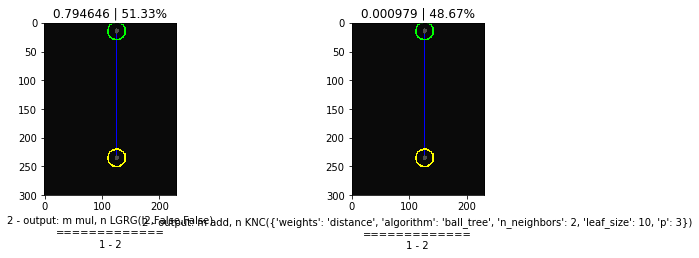

68it [00:31,  1.63s/it].250000 Species: 2 Last fitness: 0.627414 [] (Elapsed Time: 0:00:30) /  2.2 individuals/s

In [ ]:
once = False
#evhist = []
best_ever = 0
best_gs = []

nfl = 1
g = NEAT.Genome(0, num_inputs, 1, num_outputs, 0, NEAT.ActivationFunction.RELU,
                    NEAT.ActivationFunction.RELU, 0, params, 0, nfl)
pop = NEAT.Population(g, params, True, 1.0, 0)
pop.RNG.Seed(int(time.clock()*100))
#pop.Parameters.AllowClones = False
evhist = []

# rtNEAT code
try:
    
    if initeval: 
        if verbose:
            print('============================================================')
            print("Please wait for the initial evaluation to complete.")
        now = time.time()
        genome_list = []
        for s in pop.Species:
            for i in s.Individuals:
                genome_list.append(i)
        sys.stdout.flush()
        # turn them into NX networks
        grlist = [NEAT.Genome2NX(x, with_weights=1) for x in genome_list]
        ltrlist = [x.GetLinkTraits(1) for x in genome_list]
        ntrlist = [x.GetNeuronTraits() for x in genome_list]
        idlist = [x.GetID() for x in genome_list]
        if parallel:
            args = list(zip(idlist,
                            grlist,
                            [fx]*len(grlist),
                            [fy]*len(grlist),
                            ltrlist,
                            ntrlist, 
                            [precomp]*len(grlist)
                            ))
        else:
            args = list(zip(idlist,
                            grlist,
                            [dx]*len(grlist),
                            [dy]*len(grlist),
                            ltrlist,
                            ntrlist,
                            [precomp]*len(grlist)
                            ))

        # evaluate all individuals
        fitnesses = [0] * len(grlist)
        if verbose:
            bar = ProgressBar(initial_value=0, max_value=len(grlist))
        fff = {}
        rss = {}
        if parallel:
            cp = [client.submit(evaluate, x) for x in args]
            for i,ftr in enumerate(as_completed(cp)):
                idx, fitness, rsx  = ftr.result()
                fff[idx] = fitness
                rss[idx] = rsx
                if verbose:
                    bar.update(i)
        else:
            for i in range(len(grlist)):
                idx, fitness, rsx = evaluate(args[i])
                fff[idx] = fitness
                rss[idx] = rsx
                if verbose:
                    bar.update(i)                
        if verbose:
            bar.finish()

        fitness_list = []
        rsx_list = []
        for gnm in genome_list:
            gnm.SetFitness( fff[gnm.GetID()] )
            fitness_list.append( fff[gnm.GetID()] )
            rsx_list.append( rss[gnm.GetID()] )
            if use_local_search:
                for qx,w in zip(gnm.LinkGenes,rss[gnm.GetID()]): qx.Weight = w
            gnm.SetEvaluated()

        bidx = argmax(fitness_list)
        best = fitness_list[bidx]
        #if initeval: evhist.append(decide(best))
        if best > best_ever:
            if verbose:
                print('NEW RECORD!')
                print('Evaluations:', 0,
                      'Fitness:', decide(best),
                      'Species:', len(pop.Species))
            best_gs.append([NEAT.Genome2NX(genome_list[bidx], with_weights=1), 
                            genome_list[bidx].GetLinkTraits(1),
                            genome_list[bidx].GetNeuronTraits(),
                            rsx_list[bidx]
                           ])
            best_bs = best_gs[-3:]
            if verbose:
                print(f'-------- nodes: {genome_list[bidx].NumNeurons()} -------- ')
                print('\n'.join([str(x) for x in genome_list[bidx].GetNeuronTraits() 
                                 if x[1] != 'input'][0:max_nodeslinks_to_output]))
                print(f'-------- links: {genome_list[bidx].NumLinks()} -------- ')
                print('\n'.join([str(x) for x in genome_list[bidx].GetLinkTraits(1)][0:max_nodeslinks_to_output]))
                print('----------------------- ')
            best_ever = best
            if viz and verbose:
                species_display(pop)

        if verbose:
            print("Evaluation took", '%3.2f' % (time.time() - now), "seconds.")
            
    else: 
        # No initial evaluation, start off with small random fitness
        for s in pop.Species:
            for i in s.Individuals:
                i.SetFitness(np.random.rand()/1000)
                i.SetEvaluated()              

    if parallel: 
        genome_list = NEAT.GetGenomeList(pop)
        grlist = [NEAT.Genome2NX(x, with_weights=1) for x in genome_list]
        ltrlist = [x.GetLinkTraits(1) for x in genome_list]
        ntrlist = [x.GetNeuronTraits() for x in genome_list]
        idlist = [x.GetID() for x in genome_list]
        args = list(zip(idlist,
                        grlist,
                        [fx]*len(grlist),
                        [fy]*len(grlist),
                        ltrlist,
                        ntrlist,
                        [precomp]*len(grlist)
                        ))
        cp = [client.submit(evaluate, x) for x in args]

    if verbose: 
        print('============================================================')
        print('rtNEAT phase')
        print('============================================================')

        format_custom_text = FormatCustomText('CTresh: %(ctr).6f Species: %(sp)d Last fitness: %(fitness).6f %(vr)s',
            dict(
                sp=0,
                fitness=0.0,
                vr=str([]),
                ctr=0.0,
            ),)

        widgets = ['Evaluated: ', Counter('%(value)d'), ' ', format_custom_text,
                   ' (', Timer(), ') ', RotatingMarker(), FileTransferSpeed(unit='individuals') ]
        bar = ProgressBar(widgets=widgets, initial_value=0, max_value=evaluations)

    if parallel: 
        # parallel continious loop
        seq = as_completed(cp)
        i=0
        olds = []
        under_evaluation_now = len(cp)
        for f in tqdm(seq):
            if i >= evaluations:
                [x.cancel() for x in cp]
                break
            if verbose:
                if i > 0: bar.update(i)
            i += 1

            # get result from evaluation
            idx, fitness, rsx = f.result()
            if 1:
                if idx not in olds:
                    # set that individual's fitness
                    pop.AccessGenomeByID(idx).SetFitness(fitness)
                    pop.AccessGenomeByID(idx).SetEvaluated()
                    under_evaluation_now -= 1

                    thegenome = pop.AccessGenomeByID(idx)

                    #  apply the local search back to genome
                    if use_local_search:
                        for qx,w in zip(thegenome.LinkGenes,rsx): qx.Weight = w

                    # get best fitness in population and print it
                    evhist.append(decide(fitness))
                    if fitness > best_ever:
                        if verbose:
                            print('NEW RECORD!')
                            print('Evaluations:', i,
                                  'Fitness:', decide(fitness))
                        best_gs.append([NEAT.Genome2NX(thegenome, with_weights=1),
                                        thegenome.GetLinkTraits(1),
                                        thegenome.GetNeuronTraits(),
                                        rsx
                                       ])
                        if verbose:
                            print(f'-------- nodes: {thegenome.NumNeurons()} -------- ')
                            print('\n'.join([str(x) for x in thegenome.GetNeuronTraits() if x[1] != 'input'][0:max_nodeslinks_to_output]))
                            print(f'-------- links: {thegenome.NumLinks()} -------- ')
                            print('\n'.join([str(x) for x in thegenome.GetLinkTraits(1)][0:max_nodeslinks_to_output]))
                            print('----------------------- ')
                        best_ever = fitness
                        if viz and verbose:
                            species_display(pop)
                    elif (i%display_pop_each)==0: 
                        if viz and verbose:
                            species_display(pop)

                else:
                    if verbose: 
                        print(f'Fitness of genome #{idx} was not set.')

            #except Exception as ex:
            #    print(ex)
            if verbose:
                format_custom_text.update_mapping(fitness=decide(fitness),
                                                  sp=len(pop.Species),
                                                  ctr=pop.Parameters.CompatTreshold)


            # apply exploration pressure to species
            if penalize_stangation:
                maxfit = max([x.GetFitness() for x in NEAT.GetGenomeList(pop)])
                for s in pop.Species:
                    if s.EvalsNoImprovement > penalize_stagnation_evals:
                        bf = max([x.GetFitness() for x in s.Individuals])
                        # make an exception if that species contains the best genome so far
                        if bf < maxfit:
                            for ind in s.Individuals:
                                ind.SetFitness(0.000000001)

            if all([x.EvalsNoImprovement > max_stagnation for x in pop.Species]):
                break

            # create new baby and add to list of tasks
            # only add new babies if the population under evaluation is below N%
            if under_evaluation_now <= (population*(1/3)):
                if not once:
                    once=True
                    if verbose:
                        print(f'rtNEAT reproduction cycle started at evaluation #{i}')

                old = NEAT.Genome()
                baby = pop.Tick(old)

                if old.GetID() != -1:
                    olds.append(old.GetID())

                newf = client.submit(evaluate, (baby.GetID(),
                                                NEAT.Genome2NX(baby, with_weights=1),
                                                fx,
                                                fy,
                                                baby.GetLinkTraits(1),
                                                baby.GetNeuronTraits(),
                                                precomp
                                                ))
                seq.add(newf)
                under_evaluation_now += 1

    else: 

        # continuous loop
        for i in tqdm(range(evaluations)):
            if verbose:
                bar.update(i)

            # get the new baby
            old = NEAT.Genome()
            baby = pop.Tick(old)

            # evaluate it
            f = evaluate((baby.GetID(),
                          NEAT.Genome2NX(baby, with_weights=1),
                          dx,
                          dy,
                          baby.GetLinkTraits(1),
                          baby.GetNeuronTraits(),
                          precomp
                          ))

            fitness = f[1]
            rsx = f[2]

            baby.SetFitness(fitness)
            baby.SetEvaluated()

            # apply the local search back to genome
            if use_local_search:
                for qx,w in zip(baby.LinkGenes,rsx): qx.Weight = w

            # get best fitness in population and print it
            #evhist.append(decide(fitness))
            if fitness > best_ever:
                evhist.append(fitness)
                if verbose:
                    print('NEW RECORD!')
                    print('Evaluations:', i,
                          'Fitness:', decide(fitness))
                best_gs.append([NEAT.Genome2NX(baby, with_weights=1),
                               baby.GetLinkTraits(1),
                               baby.GetNeuronTraits(),
                               rsx])
                best_bs = best_gs[-3:]
                if verbose:                    
                    print(f'-------- nodes: {baby.NumNeurons()} -------- ')
                    print('\n'.join([str(x) for x in baby.GetNeuronTraits() if x[1] != 'input'][0:max_nodeslinks_to_output]))
                    print(f'-------- links: {baby.NumLinks()} -------- ')
                    print('\n'.join([str(x) for x in baby.GetLinkTraits(1)][0:max_nodeslinks_to_output]))
                    print('----------------------- ')
                best_ever = fitness
                if viz and verbose:
                    species_display(pop)
            elif (i%display_pop_each)==0: 
                if viz and verbose:
                    species_display(pop)

            if all([x.EvalsNoImprovement > max_stagnation for x in pop.Species]):
                break

            if (i%50000)==0:
                _=gc.collect()

            #spechist.append([len(pop.Species), pop.Parameters.CompatTreshold])

            if verbose:
                format_custom_text.update_mapping(fitness=decide(f[1]),
                                                  sp=len(pop.Species),
                                                  ctr=pop.Parameters.CompatTreshold)

except KeyboardInterrupt:
    pass

except Exception as ex:
    print(ex)

In [ ]:
#%debug

In [ ]:
plot(array(evhist)[array(evhist)>0.50]);

In [ ]:
best_gs[-1]

In [ ]:
np.sum(activate_graph(best_gs[-1][0], [dx], dy, num_outputs=1, fit=True).reshape(-1) == dy.reshape(-1)) / dy.shape[0]

In [ ]:
client.restart(timeout=600)

In [ ]:
# make submission
mytest = dx_test_df.iloc[:,1:9].values

In [ ]:
activate_graph(best_gs[-1][0], [mytest], dy, num_outputs=1, fit=True).reshape(-1)

In [ ]:
testPredictions = activate_graph(best_gs[-1][0], [mytest], dy, num_outputs=1, fit=True).reshape(-1)
pdtest = pd.DataFrame({'PassengerId': dx_test_df.PassengerId.astype(int),
                        'Survived': testPredictions.astype(int)})
pdtest.to_csv('titanic_skneat_1.csv', index=False)# make submission